In [2]:
import sys
!{sys.executable} -m pip install openmeteo-requests;
!{sys.executable} -m pip install requests-cache retry-requests numpy pandas;

In [46]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": -27.5967,
    "longitude": -48.5492,
    "hourly": ["winddirection_1000hPa", "winddirection_975hPa", "winddirection_950hPa", "winddirection_925hPa", "winddirection_900hPa", "winddirection_850hPa", "geopotential_height_1000hPa", "geopotential_height_975hPa", "geopotential_height_950hPa", "geopotential_height_925hPa", "geopotential_height_900hPa", "geopotential_height_850hPa"],
    "forecast_days": 16,
    "models": "ecmwf_ifs04"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_winddirection_1000hPa = hourly.Variables(0).ValuesAsNumpy()
hourly_winddirection_975hPa = hourly.Variables(1).ValuesAsNumpy()
hourly_winddirection_950hPa = hourly.Variables(2).ValuesAsNumpy()
hourly_winddirection_925hPa = hourly.Variables(3).ValuesAsNumpy()
hourly_winddirection_900hPa = hourly.Variables(4).ValuesAsNumpy()
hourly_winddirection_850hPa = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}
hourly_data["winddirection_1000hPa"] = hourly_winddirection_1000hPa
hourly_data["winddirection_975hPa"] = hourly_winddirection_975hPa
hourly_data["winddirection_950hPa"] = hourly_winddirection_950hPa
hourly_data["winddirection_925hPa"] = hourly_winddirection_925hPa
hourly_data["winddirection_900hPa"] = hourly_winddirection_900hPa
hourly_data["winddirection_850hPa"] = hourly_winddirection_850hPa


hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates -27.200000762939453°N -48.80000305175781°E
Elevation 16.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


TypeError: VariablesWithTime.Variables() missing 1 required positional argument: 'j'

In [15]:
# ... (resto do código)

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Define the path and filename
filename = "C:\\Users\\viidi\\Downloads\\arquivos nc\\wind-dir-speed_geopot_ecmwf_forecast_18-05-2024_28-03-2024.csv"

# Save the DataFrame to a CSV file with a semicolon as the separator
hourly_dataframe.to_csv(filename, sep=';', index=False)

                         date  winddirection_1000hPa  winddirection_975hPa  \
0   2024-03-18 00:00:00+00:00             143.130020            151.476974   
1   2024-03-18 01:00:00+00:00             145.304779            147.994659   
2   2024-03-18 02:00:00+00:00             158.198532            144.926163   
3   2024-03-18 03:00:00+00:00             172.875076            141.499329   
4   2024-03-18 04:00:00+00:00             180.000000            138.918350   
..                        ...                    ...                   ...   
379 2024-04-02 19:00:00+00:00                    NaN                   NaN   
380 2024-04-02 20:00:00+00:00                    NaN                   NaN   
381 2024-04-02 21:00:00+00:00                    NaN                   NaN   
382 2024-04-02 22:00:00+00:00                    NaN                   NaN   
383 2024-04-02 23:00:00+00:00                    NaN                   NaN   

     winddirection_950hPa  winddirection_925hPa  winddirection_

In [40]:
import pandas as pd

# Read the CSV file into a DataFrame
filename = "C:\\Users\\viidi\\Downloads\\arquivos nc\\wind_ecmwf_forecast_18-05-2024_28-03-2024.csv"
data = pd.read_csv(filename, sep=';')

# Print the column names
print(data.columns)

Index(['date', 'winddirection_1000hPa', 'winddirection_975hPa',
       'winddirection_950hPa', 'winddirection_925hPa', 'winddirection_900hPa',
       'winddirection_850hPa', 'shear_1000_975', 'shear_975_950'],
      dtype='object')


In [24]:
data = pd.read_csv(filename, sep=';')

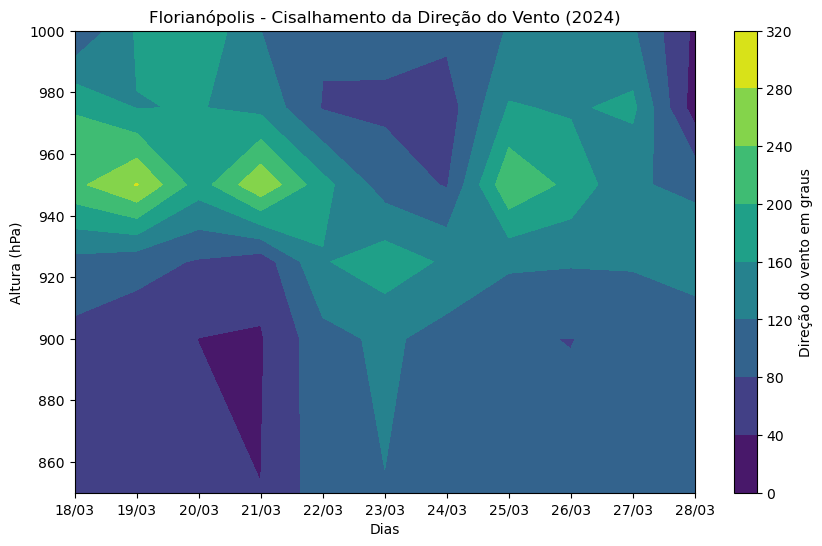

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
filename = "C:\\Users\\viidi\\Downloads\\arquivos nc\\wind_ecmwf_forecast_18-05-2024_28-03-2024.csv"
data = pd.read_csv(filename, sep=';')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Melt the DataFrame to have 'date', 'height' and 'winddirection' columns
melted_data = data.melt(id_vars='date', var_name='height', value_name='winddirection')

# Extract the numeric part of the 'height' column to get the actual height values
melted_data['height'] = melted_data['height'].str.extract('(\d+)').astype(int)

# Group by 'date' and 'height' and calculate the mean wind direction
grouped_data = melted_data.groupby(['date', 'height'])['winddirection'].mean().reset_index()

# Convert wind direction to range 0-360
grouped_data['winddirection'] = grouped_data['winddirection'] % 360

# Convert the 'date' column to 'day/month' format
grouped_data['date'] = grouped_data['date'].dt.strftime('%d/%m')

# Pivot the data to create a 2D grid
pivot_table = grouped_data.pivot_table(index='height', columns='date', values='winddirection', aggfunc='mean')

# Create the contour plot
plt.figure(figsize=(10, 6))
plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='viridis')
plt.colorbar(label='Direção do vento em graus')
plt.xlabel('Dias')
plt.ylabel('Altura (hPa)')
plt.title('Florianópolis - Cisalhamento da Direção do Vento (2024)')
plt.show()

In [37]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.
